# Определение стоимости автомобилей

<font size="4"><b>Описание проекта</b></font>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<font size="4"><b>Описание данных</b></font>

Данные находятся в файле /datasets/autos.csv. 

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

Price — цена (евро)

<font size="4"><b>Цель исследования</b></font>

Построить модель для рассчета стоимости автомобиля в разрабатываемом приложении.


<font size="4"><b>Ход исследования</b></font>

**1. Загрузка данных**

**2. Обучение и проверка модели для каждого региона:**

- Разбивка данных на обучающую и валидационную выборки в соотношении 75:25.
- Обучение модели и предсказание на валидационной выборке.
- Сохранение предсказания и правильных ответов на валидационной выборке.
- Печать на экране среднего запаса предсказанного сырья и RMSE модели.
- Анализ результатов.

**3. Подготовка к расчёту прибыли:**

- Сохранение всех ключевых значений для расчётов в отдельных переменных.
- Рассчет достаточного объёма сырья для безубыточной разработки новой скважины. 
- Сравнение полученного объёма сырья со средним.
- Анализ результатов.

**4. Написание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели:**

- Выбор скважины с максимальными значениями предсказаний. 
- Расчет суммы целевого значение объёма сырья, соответствующее этим предсказаниям.
- Рассчет прибыли для полученного объёма сырья.
 
**5. Просчет рисков и прибыли для каждого региона:**

- Применение техники Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Поиск средней прибыли, 95%-й доверительного интервала и риска убытков. 
- Анализ результатов.

**6. Формирование общего вывода**

In [1]:
# Обновим используемые библиотеки
!pip install phik -q
!pip install catboost -q
!pip install scikit-learn==1.1.3 -q

In [2]:
#Загрузим все библиотеки
import pandas as pd
from phik import phik_matrix
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler,
    OrdinalEncoder,
    OneHotEncoder
)
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import time


## Подготовка данных

### Посмотрим общую информацию по датасету

In [3]:
autos = pd.read_csv("/datasets/autos.csv")

In [4]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
#проверим пропуски
autos.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
#проверим  дубликаты в данных
autos.duplicated().sum()

4

**Предварительный вывод**

В датафрейме присутствует 354369 строки, в толбцах VehicleType, Gearbox, Model, FuelType, Repaired имеются множество пропусков, в данных видны аномалии.

### Предобработка данных¶

In [9]:
#удаляем дуликаты:
autos.drop_duplicates(inplace=True)  

In [10]:
# Измененим стиль заголовков столбцов для равности картинки
autos.columns = autos.columns.str.replace(r"([A-Z])", r" \1", regex=True).str.lower().str.replace(' ', '_').str[1:]
print(autos.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


Предлагаю удалить толбцы, которые не смогут повлиять на цену: 
- дата скачивания анкеты, дата появления обьявления и дата последней активности никак не влияют на ценообразование, лишь дают сведения, на сколько активен владелец.
- Количество фото авто так же не влияет на цену, только на скорость продажи, потому что чем больше фото, тем лучше видно авто, и тем быстрее его заберут.
- почтовый индекс анкеты - создать анкету можно из любой точки мира, цена все равно будет складываться от региона нахождения
- месяц регистрации авто - ни одна страна не различает стоимость регистрации по месяцам, что означает равную цену на все авто всех периодов.


In [11]:
#удалим столбцы, которые не смогут повлиять на цену
autos.drop(columns=['date_crawled',
                    'date_created',
                    'number_of_pictures',
                    'postal_code',
                    'last_seen',
                    'registration_month'],axis=1,inplace=True)

In [12]:
autos.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


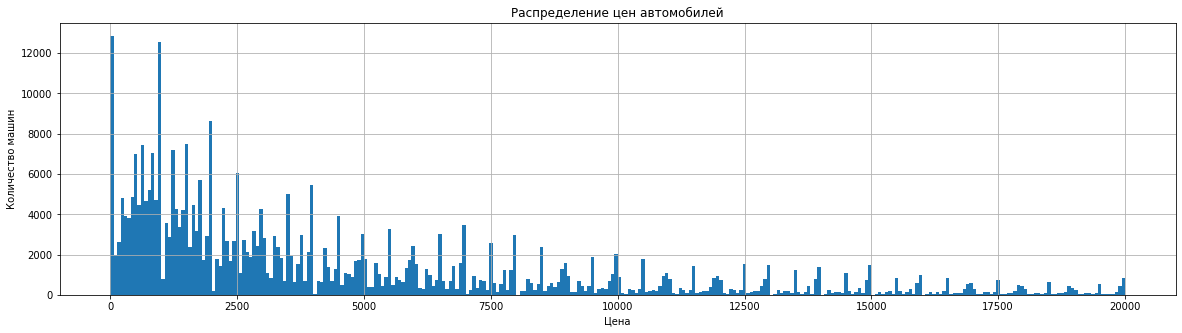

In [13]:
# посмотрим на данные цен с помощью графика
plt.figure(figsize=(20, 5))
autos.price.hist(bins=300)
plt.title('Распределение цен автомобилей')
plt.xlabel('Цена')
plt.ylabel('Количество машин')
plt.grid(True)
plt.show()

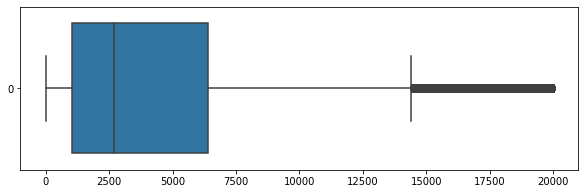

In [14]:
#дополнительно посмотрим ящик с усами, тк по графику выбросы плохо понятны
plt.figure(figsize=(10,3))
sns.boxplot(data=autos.price, orient='h')
plt.show()

Предлагаю отбросить автос ценами ниже 50 евро для более реальной оценки

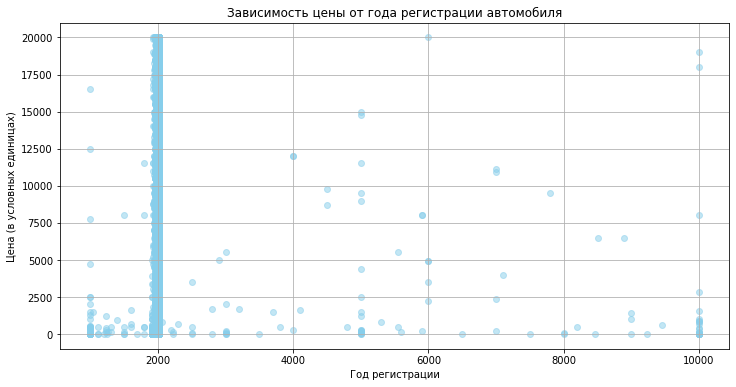

In [15]:
# Создание гистограммы для отображения зависимости цены от года регистрации
plt.figure(figsize=(12, 6))
plt.scatter(autos['registration_year'], autos['price'], alpha=0.5, color='skyblue')
plt.title('Зависимость цены от года регистрации автомобиля')
plt.xlabel('Год регистрации')
plt.ylabel('Цена (в условных единицах)')
plt.grid(True)
# Отображаем гистограмму
plt.show()

Предлагаю взять авто с годом выпуска, начиная с 1960года, так как ниже уже почти раритет и спроса не будет. Так же, нужно удалить все, что выше 16 года, это явная ошибка

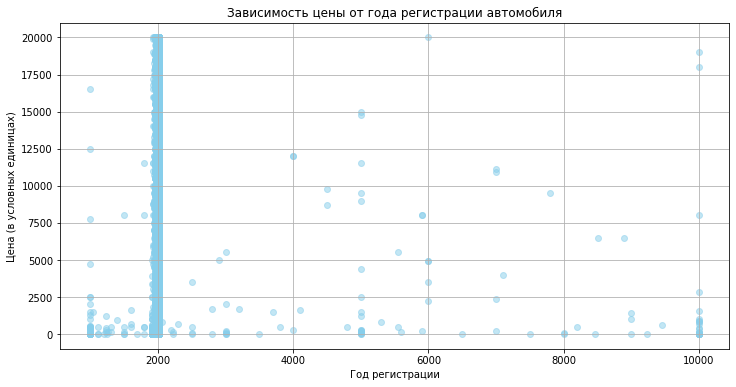

In [16]:
# Создание гистограммы для отображения зависимости цены от года регистрации
plt.figure(figsize=(12, 6))
plt.scatter(autos['registration_year'], autos['price'], alpha=0.5, color='skyblue')
plt.title('Зависимость цены от года регистрации автомобиля')
plt.xlabel('Год регистрации')
plt.ylabel('Цена (в условных единицах)')
plt.grid(True)
# Отображаем гистограмму
plt.show()

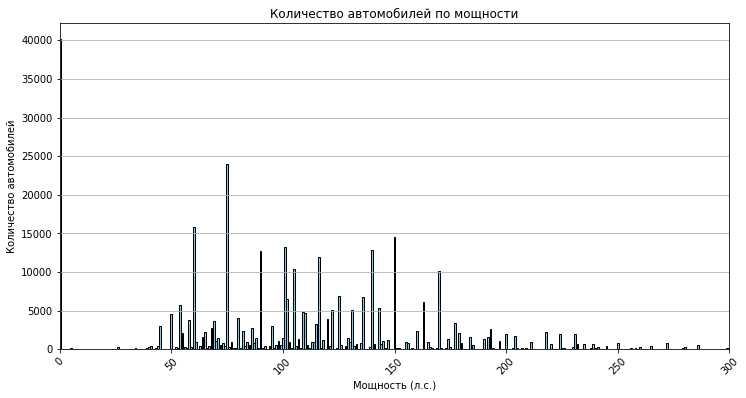

In [17]:
# Подсчет количества автомобилей для каждой уникальной мощности
power_counts = autos['power'].value_counts().sort_index()
# Создание столбчатой диаграммы
plt.figure(figsize=(12, 6))
plt.bar(power_counts.index, power_counts.values, color='skyblue', edgecolor='black')
plt.title('Количество автомобилей по мощности')
plt.xlabel('Мощность (л.с.)')
plt.ylabel('Количество автомобилей')
plt.grid(axis='y')
plt.xlim(0, 300)
plt.xticks(rotation=45)  # Поворот меток по оси X для лучшей читаемости
plt.show()

До 40 л.с. массовых авто нет, а после 600 л.с. идут спорткары, но в нашем датасете их тоже нет. Поэтому обозначим диапазон

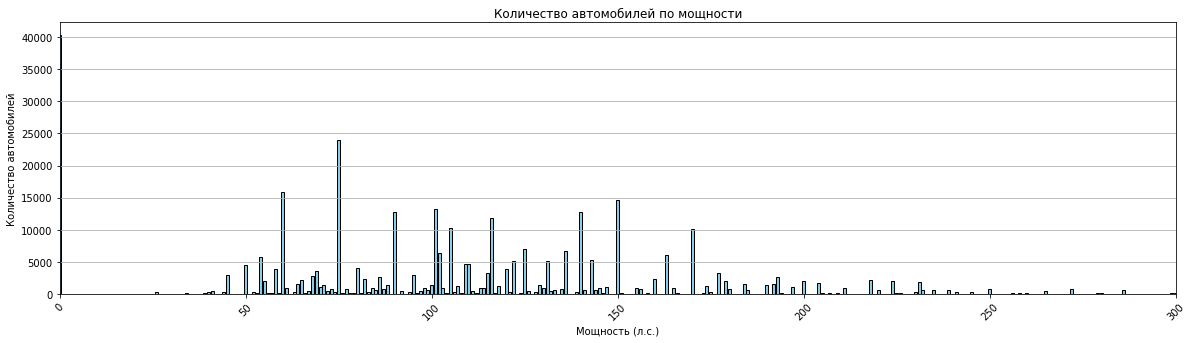

In [18]:
# Подсчет количества автомобилей для каждой уникальной мощности
power_counts = autos['power'].value_counts().sort_index()
# Создание столбчатой диаграммы
plt.figure(figsize=(20, 5))
plt.bar(power_counts.index, power_counts.values, color='skyblue', edgecolor='black')
plt.title('Количество автомобилей по мощности')
plt.xlabel('Мощность (л.с.)')
plt.ylabel('Количество автомобилей')
plt.grid(axis='y')
plt.xlim(0, 300)
# Отображаем столбчатую диаграмму
plt.xticks(rotation=45)  # Поворот меток по оси X для лучшей читаемости
plt.show()

Удалим все выбраные ранее аномалии

In [19]:
autos = autos.query('price > 50 & registration_year >= 1960 & registration_year <= 2016 & power >= 40 & power <= 600')

В столбцах слишком большое количество пропусков, 7-9%, поэтому предлагаю не удалять их, а заполнить пропуски

In [20]:
autos = autos.fillna('unknown')
autos.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [21]:
#проверим пропуски
autos.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Проверим на неявные дубликаты

In [22]:
autos['vehicle_type'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'unknown', 'other'], dtype=object)

In [23]:
autos['gearbox'].unique()

array(['manual', 'auto', 'unknown'], dtype=object)

In [24]:
autos['model'].unique()

array(['unknown', 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er',
       'b_klasse', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', 'astra', '156', 'escort', 'forester', 'xc_reihe',
       'scenic', 'ka', 'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega',
       'slk', '7er', 'combo', 'corsa', '80', '147', 'z_reihe', 'sorento',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia', 'almera',
       'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider', 'cuore',
     

In [25]:
autos['fuel_type'].unique()

array(['gasoline', 'petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

'gasoline', 'petrol' имеют одно и тоже значение, предлагаю обьеденить столбцы.

In [26]:
autos['fuel_type'] = autos['fuel_type'].replace({'petrol': 'gasoline'})
autos['fuel_type'].unique()

array(['gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

После всех изменений снова проверим таблицу на наличие полных дубликатов

In [27]:
# Проверка полных дубликатов
autos.duplicated().sum()


39697

In [28]:
# Проверка полных дубликатов
print(autos.duplicated().sum())
# Подсчет процента полных дубликатов от общего количества записей
percentage_duplicates = (autos.duplicated().sum() / autos.shape[0]) * 100
print(f"Процент полных дубликатов: {percentage_duplicates:.2f}%")

39697
Процент полных дубликатов: 13.49%


In [29]:
# Удалим их
autos.drop_duplicates()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,gasoline,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354361,5250,unknown,2016,auto,150,159,150000,unknown,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,gasoline,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,gasoline,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


**Предварительный вывод**

На данном этапе были заполнены все пропуски в датафрейме на unknown, все данные привели к единому стилю и регистру, обьеденены столбцы с типом топлива бензин, а так же, были удалены столбцы, не зависящие от цены для оптимизации последующего обучения модели. Помимо, исключили машины до 1960 и после 2016 года. Так же, Исключили авто стоимостью до 50 евро. После снова проверили на дубликаты и удалили для чистоты датафрейма, ыто составило 13,5% потерь.

###  Корреляция данных¶

In [30]:
#Выделим признак
column=['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired']

In [31]:
autos_с = autos[column]
# Вычислим корреляцию
corr_matrix = autos_с.corr()
corr_matrix

,price,registration_year,power,kilometer
price,1.000000,0.504110,0.511658,-0.391820
registration_year,0.504110,1.000000,0.122675,-0.322333
power,0.511658,0.122675,1.000000,0.096827
kilometer,-0.391820,-0.322333,0.096827,1.000000


interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer']


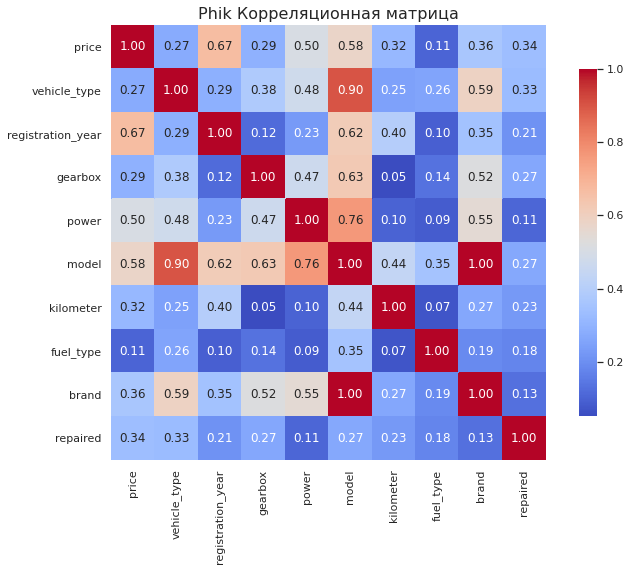

In [32]:
# Вычисляем Phik корреляционную матрицу
phik_matrix_result = autos.phik_matrix()
plt.figure(figsize=(12, 8))
sns.set_theme(style="white")
# Создаем тепловую карту
sns.heatmap(phik_matrix_result, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Phik Корреляционная матрица', fontsize=16)
plt.show()

**Предварительный вывод**

Матрица корреляции Phik, представленная в таблице, выявляет несколько ключевых взаимосвязей между характеристиками автомобилей. В первую очередь, модель автомобиля жестко связана с брендом (корреляция 1.00), что логично, поскольку каждая модель производится конкретным производителем. Удалим бренд авто, чтобы он не дублировал марку.  Далее, тип автомобиля тесно связан с моделью (корреляция 0.90), что указывает на то, что определенные типы автомобилей чаще ассоциируются с конкретными производителями и моделями. Например, внедорожники, вероятно, будут чаще встречаться в модельных рядах брендов, специализирующихся на таком типе транспортных средств.

Мощность двигателя также связана с моделью (корреляция 0.76), что говорит о том, что более мощные двигатели чаще устанавливаются на определенные модели, например, спортивные автомобили или пикапы. Ожидаемо, что цена автомобиля коррелирует с годом регистрации (0.67), так как более новые автомобили, как правило, имеют более высокую цену из-за амортизации. Кроме того, цена автомобиля также связана с мощностью (0.50), что отражает тот факт, что более мощные двигатели часто увеличивают общую стоимость автомобиля.

Интересно, что пробег (kilometer) демонстрирует слабую корреляцию со всеми другими характеристиками, что позволяет предположить, что сам по себе пробег не является основным определяющим фактором в этих взаимосвязях. Это может означать, что другие характеристики, такие как возраст, тип автомобиля и мощность двигателя, оказывают более сильное влияние на общие характеристики автомобиля, чем просто пройденное расстояние.


In [33]:
# Удаляем столбец 'brand' из датафрейма autos
autos = autos.drop('brand', axis=1)

### Вывод по разделу

Датафрейм был успешно оптимизирован и подготовлен к использованию в машинном обучении.

Анализ корреляционной матрицы Phik выявил несколько значительных взаимосвязей между характеристиками автомобилей. Наиболее выраженная корреляция наблюдается между моделью и брендом (1.00), что логично, поскольку каждая модель принадлежит конкретному производителю. При обучении модели, предлагаю удалить признак брнда авто, так как он дублирует марку. Также показано, что тип автомобиля тесно связан с моделью (0.90), и мощность двигателя имеет заметное значение в этом контексте (0.76). Цены автомобилей коррелируют с годом регистрации (0.67) и мощностью (0.50), в то время как пробег показывает слабую взаимосвязь с другими характеристиками. На этапе обработки данных все пропуски были заменены на "unknown", стиль и регистр выровнены, объединены записи о типе топлива, а также удалены незначимые столбцы. Исключены автомобили старше 2016 года и младше 1960 года, а также те, цена которых составила менее 50 евро, приведя к 13,5% потерь данных после удаления дубликатов и для повышения чистоты датафрейма.

## Обучение моделей

### Готовим данные к обучению

In [34]:
# Выделяем признаки и целевой признак
X = autos.drop('price', axis=1)
y = autos['price']

# Делим данные на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=12345)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5, random_state=12345)

# Определяем числовые и категориальные признаки
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

# Создаем трансформатор для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  
        ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first'), categorical_features)])

### Модель линейной регрессии

In [35]:
# Обучим модель линейной регрессии используя преобразованные данные
# Создаем модель
model = LinearRegression()
# Кодируем данные
X_train_encoded = preprocessor.fit_transform(X_train)
X_valid_encoded = preprocessor.transform(X_valid)
# Обучим модель
model.fit(X_train_encoded, y_train)
# Построим предсказания на обучающей выборке
predictions_train_lr = model.predict(X_train_encoded)
# Найдем корень из квадратичной средней ошибки (RMSE) на обучающей выборке
rmse_train_lr = mean_squared_error(y_train, predictions_train_lr) ** 0.5
print("RMSE на тренировочной выборке:", rmse_train_lr)
# Также можно сделать предсказания на валидационной выборке
predictions_valid_lr = model.predict(X_valid_encoded)
# Найдем RMSE на валидационной выборке
rmse_valid_lr = mean_squared_error(y_valid, predictions_valid_lr) ** 0.5
print("RMSE на валидационной выборке:", rmse_valid_lr)
# Анализ Linear Regression
start_train_lr = time.time()
model_lr = LinearRegression().fit(X_train_encoded, y_train)
end_train_lr = time.time()
training_time_lr = end_train_lr - start_train_lr
print(f"Время обучения модели Linear Regression: {training_time_lr:.4f} сек")
start_pred_lr = time.time()
predictions_train_lr = model_lr.predict(X_train_encoded)
predictions_valid_lr = model_lr.predict(X_valid_encoded)
end_pred_lr = time.time()
prediction_time_lr = end_pred_lr - start_pred_lr
print(f"Время предсказания модели Linear Regression: {prediction_time_lr:.4f} сек")

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RMSE на тренировочной выборке: 2593.8371194041306
RMSE на валидационной выборке: 2612.506523576379
Время обучения модели Linear Regression: 28.4916 сек
Время предсказания модели Linear Regression: 0.2898 сек


Согласно приведенным условиям, значение метрики RMSE должно быть меньше 2500. На тренировочной выборке RMSE 2594, и валидационной выборке RMSE 2613, что пока не позволяет считать задачу выполненной. Время обучения 28 секунд,


### Модель регрессии CatBoost.

In [36]:
# Обучим модель CatBoostRegressor
model = CatBoostRegressor(iterations=200, learning_rate=0.1, depth=6, cat_features=categorical_features, verbose=0)
# Обучаем модель
model.fit(X_train, y_train)
# Предсказания на обучающей выборке
predictions_train_cb = model.predict(X_train)
# Рассчитываем RMSE на обучающей выборке
rmse_train_cb = mean_squared_error(y_train, predictions_train_cb) ** 0.5
print("RMSE на _cb выборке:", rmse_train_cb)
# Также делаем предсказания на валидационной выборке
predictions_valid_cb = model.predict(X_valid)
# Рассчитываем RMSE на валидационной выборке
rmse_valid_cb = mean_squared_error(y_valid, predictions_valid_cb) ** 0.5
print("RMSE на валидационной выборке:", rmse_valid_cb)
# Анализ CatBoost Regressor
start_train_cb = time.time()
model_cb = CatBoostRegressor(iterations=200, learning_rate=0.1, depth=6, cat_features=categorical_features, verbose=0)
model_cb.fit(X_train, y_train)
end_train_cb = time.time()
training_time_cb = end_train_cb - start_train_cb
print(f"\nВремя обучения модели CatBoostRegressor: {training_time_cb:.4f} сек")
start_pred_cb = time.time()
predictions_train_cb = model_cb.predict(X_train)
predictions_valid_cb = model_cb.predict(X_valid)
end_pred_cb = time.time()
prediction_time_cb = end_pred_cb - start_pred_cb
print(f"Время предсказания модели CatBoostRegressor: {prediction_time_cb:.4f} сек")

RMSE на _cb выборке: 1715.1992151788584
RMSE на валидационной выборке: 1734.2285186828217

Время обучения модели CatBoostRegressor: 31.9922 сек
Время предсказания модели CatBoostRegressor: 0.4874 сек


CatBoost показывает значительно лучшие результаты на обеих выборках RMSE около 1730, по сравнению с линейной регрессией. Время обучения так же, в районе 30 секунд.

### Модель LGBMRegressor

In [38]:
# Обучим модель LGBMRegressor
model_lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=-1)
# Обучаем модель
model_lgbm.fit(X_train_encoded, y_train)
# Предсказания на обучающей выборке
predictions_train_lgbm = model_lgbm.predict(X_train_encoded)
# Рассчитываем RMSE на обучающей выборке
rmse_train_lgbm = mean_squared_error(y_train, predictions_train_lgbm) ** 0.5
print("RMSE на тренировочной выборке:", rmse_train_lgbm)
# Также делаем предсказания на валидационной выборке
predictions_valid_lgbm = model_lgbm.predict(X_valid_encoded)
# Рассчитываем RMSE на валидационной выборке
rmse_valid_lgbm = mean_squared_error(y_valid, predictions_valid_lgbm) ** 0.5
print("RMSE на валидационной выборке:", rmse_valid_lgbm)
# Анализ LightGBM Regressor
start_train_lgbm = time.time()
model_lgbm = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=-1)
model_lgbm.fit(X_train_encoded, y_train)
end_train_lgbm = time.time()
training_time_lgbm = end_train_lgbm - start_train_lgbm
print(f"\nВремя обучения модели LGBMRegressor: {training_time_lgbm:.4f} сек")
start_pred_lgbm = time.time()
predictions_train_lgbm = model_lgbm.predict(X_train_encoded)
predictions_valid_lgbm = model_lgbm.predict(X_valid_encoded)
end_pred_lgbm = time.time()
prediction_time_lgbm = end_pred_lgbm - start_pred_lgbm
print(f"Время предсказания модели LGBMRegressor: {prediction_time_lgbm:.4f} сек")

RMSE на тренировочной выборке: 1612.8552115714692
RMSE на валидационной выборке: 1651.9075358023715

Время обучения модели LGBMRegressor: 581.1153 сек
Время предсказания модели LGBMRegressor: 4.3890 сек


LGBMRegressor показала себя немного лучше на обеих выборках, по сравнению с CatBoost.

### Вывод по разделу

По результатам сравнения трех моделей, LGBMRegressor показал наилучшие значения RMSE как на тренировочной (RMSE 1613), так и на валидационной выборке (RMSE 1652), что подтверждает его высокую эффективность в задачах регрессии. CatBoost следует за ним с хорошими результатами, при этом лучше, чем линейная регрессия, которая значительно уступает обеим более сложным моделям по обеим метрикам. Эти результаты подчеркивают эффективность градиентного бустинга как лучшего подхода для данной задачи, особенно в ситуациях, когда данные могут быть как числовыми, так и категориальными.

## Анализ моделей

Проанализируем время обучения, время предсказания и качество моделей.

In [39]:
# Создаем таблицу для сравнения моделей
results = pd.DataFrame({
    'Модель': ['Linear Regression', 'CatBoostRegressor', 'LGBMRegressor'],
    'RMSE на валидации': [rmse_valid_lr, rmse_valid_cb, rmse_valid_lgbm],
    'Время обучения (сек)': [training_time_lr, training_time_cb, training_time_lgbm],
    'Время предсказания (сек)': [prediction_time_lr, prediction_time_cb, prediction_time_lgbm]
})
# Выводим таблицу
print(results)

              Модель  RMSE на валидации  Время обучения (сек)  \
0  Linear Regression        2612.506524             28.491632   
1  CatBoostRegressor        1734.228519             31.992160   
2      LGBMRegressor        1651.907536            581.115272   

   Время предсказания (сек)  
0                  0.289833  
1                  0.487381  
2                  4.388994  


In [40]:
# Выбираем лучшую модель по RMSE на валидации
best_model = results.loc[results['RMSE на валидации'].idxmin()]
print("\nЛучшая модель:")
print(best_model)


Лучшая модель:
Модель                      LGBMRegressor
RMSE на валидации             1651.907536
Время обучения (сек)           581.115272
Время предсказания (сек)         4.388994
Name: 2, dtype: object


In [41]:
# Объединяем обучающую и валидационную выборки
X_train_full = pd.concat([X_train, X_valid])
y_train_full = pd.concat([y_train, y_valid])

# Обучаем лучшую модель на объединенной выборке
if best_model['Модель'] == 'Linear Regression':
    X_train_full_encoded = preprocessor.fit_transform(X_train_full)
    X_test_encoded = preprocessor.transform(X_test)
    best_model_instance = LinearRegression()
    best_model_instance.fit(X_train_full_encoded, y_train_full)
    predictions_test = best_model_instance.predict(X_test_encoded)
elif best_model['Модель'] == 'CatBoostRegressor':
    best_model_instance = CatBoostRegressor(iterations=200, learning_rate=0.1, depth=6, cat_features=categorical_features, verbose=0)
    best_model_instance.fit(X_train_full, y_train_full)
    predictions_test = best_model_instance.predict(X_test)
elif best_model['Модель'] == 'LGBMRegressor':
    X_train_full_encoded = preprocessor.fit_transform(X_train_full)
    X_test_encoded = preprocessor.transform(X_test)
    best_model_instance = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=-1)
    best_model_instance.fit(X_train_full_encoded, y_train_full)
    predictions_test = best_model_instance.predict(X_test_encoded)
rmse_test = mean_squared_error(y_test, predictions_test) ** 0.5
print(f"RMSE на тестовой выборке: {rmse_test}")

RMSE на тестовой выборке: 1663.8171763943435


### Вывод по разделу

На основе проведенного анализа моделей, LGBMRegressor показала наилучшее качество с RMSE на валидационной выборке 1651.91, что немного лучше, чем у CatBoostRegressor (RMSE = 1734.23) и значительно превосходит Linear Regression (RMSE = 2612.51). Однако LGBMRegressor требует значительно больше времени для обучения (581.12 секунд) по сравнению с CatBoostRegressor (31.99 секунд) и Linear Regression (28.49 секунд). Время предсказания LGBMRegressor также выше (4.39 секунд), что может быть критично в задачах, требующих быстрого отклика. На тестовой выборке LGBMRegressor подтвердила свое качество с RMSE 1663.82, что близко к результату на валидации. Таким образом, LGBMRegressor является лучшей моделью по качеству предсказаний, но если время обучения и предсказания критично, стоит рассмотреть CatBoostRegressor как компромиссный вариант.

## Общий вывод

В ходе реализации проекта по предсказанию цен подержанных автомобилей была успешно достигнута поставленная цель — выбрана модель LGBMRegressor, которая продемонстрировала наилучшие результаты. Проект охватил все ключевые этапы: загрузку и анализ данных, предварительную обработку, подготовку к машинному обучению и оценку нескольких моделей, включая LGBMRegressor, CatBoostRegressor и Linear Regression.

На этапе предобработки данных были выполнены следующие шаги: все пропуски заполнены значением "unknown", данные приведены к единому стилю и регистру, объединены столбцы с типом топлива, удалены нерелевантные признаки, не влияющие на цену, а также исключены автомобили, выпущенные до 1960 года и после 2016 года, и те, стоимость которых составляла менее 50 евро. После удаления дубликатов потери данных составили 13,5%, что повысило чистоту датафрейма.

Анализ корреляционной матрицы Phik выявил значительные взаимосвязи между характеристиками автомобилей. Наиболее выраженная корреляция наблюдалась между моделью и брендом (1.00), что логично, так как каждая модель принадлежит конкретному производителю. В связи с этим признак "бренд" был удалён, чтобы избежать дублирования информации. Также выявлены тесные связи между типом автомобиля и моделью (0.90), а также мощностью двигателя и моделью (0.76). Цена автомобиля коррелировала с годом регистрации (0.67) и мощностью двигателя (0.50), в то время как пробег показал слабую связь с другими характеристиками, что указывает на его меньшую значимость в определении цены.

Сравнение моделей показало, что LGBMRegressor обеспечивает наилучшее качество предсказаний с RMSE на валидационной выборке 1651.91, что немного лучше, чем у CatBoostRegressor (RMSE = 1734.23), и значительно превосходит Linear Regression (RMSE = 2612.51). На тестовой выборке LGBMRegressor подтвердила свою эффективность с RMSE 1663.82, что близко к результату на валидации. Однако стоит отметить, что LGBMRegressor требует значительно больше времени для обучения (581.12 секунд) по сравнению с CatBoostRegressor (31.99 секунд) и Linear Regression (28.49 секунд). Время предсказания LGBMRegressor также выше (4.39 секунд), что может быть критично в задачах, требующих быстрого отклика.

Таким образом, LGBMRegressor является лучшей моделью по качеству предсказаний, но если время обучения и предсказания критично, стоит рассмотреть CatBoostRegressor как компромиссный вариант. Проект успешно продемонстрировал эффективность градиентного бустинга для задач регрессии, особенно при работе с данными, содержащими как числовые, так и категориальные признаки.